## MNIST 

![MNIST](img/mnist.JPG)

MNIST는 손으로 쓰인 숫자 이미지와 각 이미지에 대한 해당 레이블을 포함하고 있는 데이터셋이다. 이미지는 0과 9사이의 숫자로, 본 글에서는 CNN을 활용해 숫자 손글씨를 분류하는 모델을 만들어볼 것이다. 코드를 작성하기 전에 MNIST 데이터를 살펴보자

In [3]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor())

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor())

MNIST 데이터는 `dsets.MNIST`를 통해 train data와 test data로 나누어 불러올 수 있는데, `train=True`로 설정할 수 있다. pytorch가 데이터를 인식할 수 있도록 `transform=transforms.ToTensor()` 통해 tensor 형태로 변환해야 한다. 데이터를 처음 불러온다면 `download=True`로 다운로드 받을 수 있으며, 본인은 이미 다운로드를 받은 상태이기 때문에 생략했다

In [28]:
image, label = mnist_train[10]
print('이미지 사이즈: ', image.shape)
print('이미지 레이블: ',label)

이미지 사이즈:  torch.Size([1, 28, 28])
이미지 레이블:  3


In [27]:
print('이미지 픽셀의 값:\n',image[0,10,:])

이미지 픽셀의 값:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0941, 0.8196, 0.9961, 0.9961, 0.9961,
        0.6706, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


train data 중에 하나를 뽑아서 살펴보니, mnist 이미지가 28x28 사이즈 채널1 임을 확인할 수 있다. 각 픽셀의 값은 0과 1 사이의 값으로 1에 가까울수록 흰색 0에 가까울수록 검은색에 가깝다. 이미지 형태는 아래와 같다

<function matplotlib.pyplot.show(*args, **kw)>

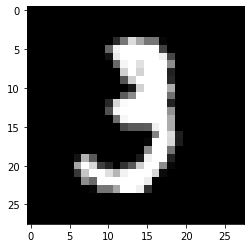

In [29]:
from matplotlib import pyplot as plt
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.show

## MNIST 데이터 CNN에 적용

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [ ]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [ ]:
learning_rate = 0.001
training_epochs = 15
batch_size=100

해당 코드는 위에서 자세히 설명했으니 넘어가도록 한다

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=100,
                                          shuffle=True,
                                          drop_last=True)

`torch.utils.data.DataLoader`는 데이터를 train하기 쉬운 형태로 가공하기 위한 패키지다. 배치 사이즈를 정하고나면 `shuffle`을 통해 데이터를 섞어서 사용할 것인지 결정할 수 있다. `drop_last`는 예를들어 데이터가 10개 배치 사이즈가 3인 경우 마지막 데이터 1개를 버릴 것인지 아닌지를 결정하는 부분이다.

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out

`forward`를 살펴보면 해당 CNN모델은 layer 2개 FC를 통과해 최종 output이 나온다. 각 layer는 convolution layer, RULU, maxpooling을 차례로 수행하는 구조다


![MNIST](img/cnn_structure.JPG)

data size가 1x3x5x5 라고 하면 batch_size가 1 채널 수가 3 이미지 사이즈가 5x5임을 기억하고 아래로 내려가자<br/>
`torch.Size([batch_Size, channel, weight, height])`


> LAYER 1

`torch.nn.Conv2d(Input channel, output channel, kernel_size, stride, padding)`<br/>
`torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)`<br/>
`torch.nn.ReLU()`<br/>
`torch.nn.MaxPool2d(kernel_size=2, stride=2)`

MNIST 데이터는 100x1x28x28사이즈로 input_channel=1이다.(현재 batch size=100으로 정의)<br/>
Conv2d를 통과한 후의 output size는  [공식](https://whdbfla6.github.io/CNN/)에 따라서 28 + 2 - 3 + 1  = 28 이고, 마지막에 max pooling을 통과하고 나면 14 x 14 사이즈가 된다

**100x1x28x28 ---conv2D--- 100x32x28x28 ---MaxPooling--- 100x32x14x14**

> LAYER 2

`torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)`<br/>
`torch.nn.ReLU()`<br/>
`torch.nn.MaxPool2d(kernel_size=2, stride=2)`
            
layer1에서 out channel의 수를 32로 지정하고 있기 때문에 layer2의 in_channel은 32로 들어가게 된다.<br/>
Conv2d를 통과한 후의 output size는 14 + 2 - 3 + 1 = 14이고, max pooling 통과 이후에 7x7 사이즈가 된다

**100x32x14x14 ---conv2D--- 100x64x14x14 ---MaxPooling--- 100x64x7x7**

> VIEW, FC

`out.view(out.size(0), -1)`<br/>

FC에 넣기 이전에 데이터를 하나로 펼치는 작업이다. batch_size가 10이기 때문에 out.size(0)=10일 것이고 최종적으로 `torch.size([100,64x7x7])`로 변환될 것이다. linear 함수에서 필요한 input_features는 64x7x7=3136이다

`torch.nn.Linear(3136, 10, bias=True)`

레이블이 0~9이기 때문에 output_features 는 10으로 설정한다

In [ ]:
model = CNN()

In [ ]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_batch = len(data_loader)

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

이 부분은 지겹게 많이 본 코드이기 때문에 생략한다

In [ ]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float()
    Y_test = mnist_test.test_labels

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

test data에서 input 이미지를 가져오기 위해서는 `mnist_test.test_data` y값 레이블을 가져오기 위해서는 `mnist_test.test_labels`을 사용하면 된다. train data에서는 `mnist_train.train_data` `mnist_train.train_labels`을 이용하자.

`mnist_test.test_data.view(len(mnist_test), 1, 28, 28)`를 통해 차원을 바꿔주는 이유를 살펴보자. 현재 input data는 10000(데이터 수)x28x28의 형태로, 지금까지 다룬 데이터의 형태인 batch_size x channel x width x height으로 맞춰주기 위해서 10000x28x28 에서 10000x1x28x28로 변환해줘야 한다

참고문헌 <br/>
[tenserflowkorea](https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/tutorials/mnist/pros/)